<a href="https://colab.research.google.com/github/waigani64/ImageAnalysis/blob/main/Dynamical_Scattereing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the crystal and electron beam parameters
a = 0.5  # Lattice constant of the crystal
b = a / np.sqrt(2)  # Lattice constant in the [1 1 0] direction
thickness = 100.0  # Thickness of the crystal in Angstroms
energy = 200.0  # Electron energy in keV
angle = 0.1  # Tilt angle of the crystal in degrees
aperture = 20.0  # Aperture size in mrad

# Define the multislice method
def multislice(wave, thickness, potential):
    n_slices = int(thickness / np.abs(wave[1] - wave[0]))
    slice_thickness = thickness / n_slices

    for i in range(n_slices):
        wave *= np.exp(-1j * potential * slice_thickness)
        wave = np.fft.ifftshift(wave)
        wave = np.fft.fft2(wave)
        wave = np.fft.fftshift(wave)
        wave *= np.exp(-1j * potential * slice_thickness)
        wave = np.fft.ifftshift(wave)
        wave = np.fft.ifft2(wave)
        wave = np.fft.fftshift(wave)

    return wave

# Define the crystal potential
def potential(x, y, z):
    return np.exp(2j * np.pi * (x/a + y/a + z/b))

# Define the electron wavevector
k = np.sqrt(2 * energy * 1000 * 1.60217662e-19 / 9.10938356e-31) / (2 * np.pi * 299792458)

# Define the tilt matrix
theta = angle * np.pi / 180
tilt_matrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])

# Define the aperture matrix
aperture_matrix = np.array([[1, 0, 0],
                            [0, 1, 0],
                            [0, 0, aperture / k]])

# Initialize the electron wave and diffraction pattern
n_pixels = 256
pixel_size = 0.2
pixel_aperture = aperture / (n_pixels * pixel_size) * k
wave = np.zeros((n_pixels, n_pixels), dtype=np.complex128)
diffraction = np.zeros((n_pixels, n_pixels), dtype=np.complex128)

# Calculate the diffraction pattern for each pixel in the detector
for i in range(n_pixels):
    for j in range(n_pixels):
        x = (i - n_pixels/2) * pixel_size
        y = (j - n_pixels/2) * pixel_size
        z = thickness / 2

        # Apply the tilt matrix and calculate the crystal potential
        xyz = tilt_matrix.dot([x, y, z])
        p = potential(xyz[0], xyz[1], xyz[2])

        # Propagate the electron wave and apply the aperture matrix
        kx = k * x / np.sqrt(x**2 + y**2 + z**2)
        ky = k * y / np.sqrt(x**2 + y**2 + z**2)
        kz = k * z / np.sqrt(x**2 + y**2 + z**2)
        wave[i,j] = np.exp(1j * (kx*x + ky*y + kz*z))


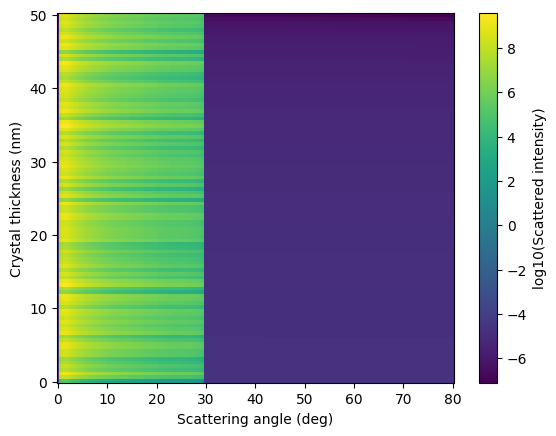

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the crystal parameters
a = 4.05  # Lattice constant in Angstrom
b = a
c = 5.21

# Define the electron beam parameters
energy = 200  # Electron energy in keV
wavelength = 12.264 / np.sqrt(energy)  # Electron wavelength in Angstrom
theta = 0  # Incident angle in degrees

# Define the thickness range
t_min = 0.1  # Minimum thickness in nm
t_max = 50  # Maximum thickness in nm
n_t = 100  # Number of thickness steps

# Define the scattering angle range
s_min = 0  # Minimum scattering angle in degrees
s_max = 80  # Maximum scattering angle in degrees
n_s = 200  # Number of scattering angle steps

# Initialize the results array
results = np.zeros((n_t, n_s))

# Loop over the thickness range
for i, t in enumerate(np.linspace(t_min, t_max, n_t)):
    # Calculate the structure factor
    h = np.arange(-10, 11)
    k = np.arange(-10, 11)
    l = np.arange(-10, 11)
    H, K, L = np.meshgrid(h, k, l, indexing='ij')
    q = 2 * np.pi / wavelength * np.sqrt(H**2*a**2 + K**2*b**2 + L**2*c**2)
    F = np.exp(-1j * q * t).sum(axis=(0,1,2))

    # Loop over the scattering angle range
    for j, s in enumerate(np.linspace(s_min, s_max, n_s)):
       # Calculate the scattered intensity
        alpha = np.radians(theta + s)
        arg = q * wavelength / (4 * np.pi) * np.sin(alpha)
        arg = np.clip(arg, -1, 1)  # Clip the argument to the valid range
        beta = np.arcsin(arg)
        I = (np.abs(F)**2 * np.sin(beta) * np.cos(beta)).sum()

        # Add the result to the array
        results[i, j] = I
        results = results + 1e-9  # add a small constant value to results to avoid zero values


# Plot the results
thicknesses = np.linspace(t_min, t_max, n_t)
scattering_angles = np.linspace(s_min, s_max, n_s)
X, Y = np.meshgrid(scattering_angles, thicknesses)
plt.pcolormesh(X, Y, np.log10(results))
plt.xlabel('Scattering angle (deg)')
plt.ylabel('Crystal thickness (nm)')
plt.colorbar(label='log10(Scattered intensity)')
plt.show()
